In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import scipy
import sys
from orf import ORF
sys.path.append("../modules")
print(sys.path)
# import constants as const
from constants import *
import equations as eq

['/Users/olivialaske/Desktop/LIGO/AR_TC/astrophysical_gwb/SNR_examples', '/Users/olivialaske/opt/anaconda3/envs/igwn-py39-lw/lib/python39.zip', '/Users/olivialaske/opt/anaconda3/envs/igwn-py39-lw/lib/python3.9', '/Users/olivialaske/opt/anaconda3/envs/igwn-py39-lw/lib/python3.9/lib-dynload', '', '/Users/olivialaske/opt/anaconda3/envs/igwn-py39-lw/lib/python3.9/site-packages', '../modules']


In [2]:
# Plot formatting
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
fontsize = 9
params = {
   'axes.labelsize': fontsize,
   'font.size': fontsize,
   'legend.fontsize': 8,
   'xtick.labelsize': fontsize,
   'ytick.labelsize': fontsize,
   'axes.titlesize': fontsize,
   'lines.linewidth': 1,  
   'xtick.direction': 'in',
   'ytick.direction': 'in',
   'font.family': 'Serif',
   'font.serif': 'Hoefler Text',
   'axes.grid': True,
   'figure.figsize': (6.75, 4),
   'figure.dpi': 250,
   'mathtext.fontset': 'cm'
}

for param in params.keys():
    matplotlib.rcParams[param] = params[param]  

In [3]:
# const.Om

In [4]:
H0SI = eq.Hubble_rate_SI(0, H0, omegaR, omegaM, omegak, omegaL)

# Understanding how we make detections

We need two detectors to detect a GW background, because we don't have a physics-based estimate of what the "signal" should look like because the signal is, by definition, random. So let's consider the data from two detectors in the frequency domain:

\begin{align}
 s_1(f) =& h_1(f) + n_1(f)\\
 s_2(f) =& h_2(f) + n_2(f),
\end{align}
where $s$ is the total data, $h_1$ is the gravitational-wave signal seen in detector 1 and $h_2$ is the same in detector 2. Note that these are different because the two detectors will respond differently to the same GW due to their orientations. $n_1$ and $n_2$ are the detector noises for each detector.

Next, we cross-correlate the data between the two detectors. The GWs will be uncorrelated with the detector noises, and (we assume) that the detector noises are uncorrelated with each other. On average, we have:

\begin{align}
\langle s_1^*(f) s_2(f)\rangle &= \langle h_1^*(f)h_2(f)\rangle + \langle h_1 n_2\rangle + \langle n_1 h_2\rangle + \langle n_1 n_2\rangle\\
&=\langle h^*_1(f) h_2(f)\rangle.
\end{align}

The last three terms went away because of our assumption that those terms are uncorrelated with one another. In this case $\langle \cdot \rangle$ indicates an *ensemble average* in theory, and in practice we calculate this quantity on real data many times on short time chunks and average those time chunks together.

Because detectors $1$ and $2$ see the same GW with different sensitivities due to their orientations, the cross-correlation itself is proportional to the *strain power spectral density of GWs*, $H(f)$ with some suppresion factor $\gamma(f)$: 
\begin{align}
 \langle h_1^*(f) h_2(f)\rangle =\frac{1}{T} \gamma(f) H(f),
\end{align}
where $\gamma(f) < 1$ and $T$ is the observation time.

In practice, we calculate $\langle s_1^*(f)s_2(f)\rangle$ and construct a statistic that is proportional to the GW background:
\begin{align}
\hat C(f) = \frac{2\textrm{Re}[s_1^*(f)s_2(f)]}{T\gamma(f)S_0(f)}\\
\langle \hat C(f)\rangle = \Omega_{\textrm{gw}}(f),
\end{align}
where $S_0(f)=3H_0^2 / (10\pi^2f^3)$ are a set of constants that satisfy the second line. We can also calculate a theoretical variance on this quantity, $\sigma^2(f) = \langle \hat C \hat C\rangle - \langle \hat C\rangle^2$. When you do this, you will find terms that include $H(f)$ but also terms line $P_1(f) = \langle n_1(f) n_1(f)\rangle$. In general, we assume that the PSD in detectors 1 and 2 are much bigger than the PSD of GWs. That is, $P_1(f) \gg H(f)$. When we do this, we find the variance on $\hat C(f)$,
\begin{align}
\sigma^2(f) = \frac{1}{2\Delta f T}\frac{P_1(f) P_2(f)}{\gamma^2(f) S_0^2(f)}.
\end{align}

Again, $T$ is the observation time and $\Delta f$ is the frequency bin width. Now we have a statistic that estimates $\Omega_{gw}(f)$ at each frequency, and its associated uncertainty. We could fit this using Bayesian methods, and indeed we will in a separate notebook. But we also often construct an "optimal statistic" that is sensitive to the case where $\Omega_{gw}(f)$ takes on a power law with a spectral index of $\alpha$:
\begin{align}
\Omega_{gw}(f) = \Omega_{ref, \alpha}\left(\frac{f}{f_{ref}}\right)^\alpha,
\end{align}
where $f_{ref}$ is a reference frequency where we report our background, and $\alpha$ gives us the shape of our power law. We can then construct an "optimal estimator" for $\Omega_{ref, \alpha}$:
\begin{align}
\hat\Omega_{ref,\alpha} = \frac{\sum_{f}\hat C(f) w_\alpha(f)\sigma^{-2}(f)}{\sum_f w^2_\alpha(f)\sigma^{-2}(f)},\\
\sigma^2_{ref,\alpha} = \left(\sum_f w_\alpha^2(f)\sigma^{-2}(f)\right)^{-1}.
\end{align}
Let's break this down -- this clearly looks like a projection of our data onto $w_\alpha$, which we'll define in a moment. The $\sigma^{-2}$ represents an inverse-noise-weight, which says that we down-weight frequency bins with large noise and upweight frequency bins with less noise. This makes intuitive sense. In the end $w_\alpha$ just represents a simple "template" for our power law (but is more like a "unit vector")
\begin{align}
w_\alpha(f) =\left(\frac{f}{f_{ref}}\right)^{\alpha}.
\end{align}

If we guess the right value for $\alpha$, then we find $\hat\Omega_{ref,\alpha} = \Omega_{ref,\alpha}$, i.e. our statistic is unbiased--it returns the true value of the spectrum at that point. From here, we typically calculate a signal-to-noise ratio:
\begin{align}
\textrm{SNR}_\alpha = \frac{\hat\Omega_{ref,\alpha}}{\sigma_{ref,\alpha}}.
\end{align}


Often, what we do when we ask questions like "when can we detect a background" is we put in estimates for $P_1(f)$ and $P_2(f)$ and $T$ to calculate $\sigma$, we set $\textrm{SNR}=5$, and we back out a value of $\hat\Omega_{gw}$ that would give us this SNR. 

What we'll do instead is assume $P_1(f)$, $P_2(f)$ and $T$, and we will calculate $\Omega_{gw}(f)$ for our different spin distributions and calculate SNR for each of those spin distributions. To calculate the SNR, we will use the "typical assumption" we make which is $\alpha=2/3$ for the inspiral of binaries. This will tell us how sensitive we are to the background for a give spin distribution "for a typical search". 

We can also estimate $\alpha$ for each of our simulations and try to see when we can distinguish between models. We'll cover that in a separate notebook, but at minimum, we could just us a linear fit to $\ln\Omega_{gw}(f)$ vs $\ln f$ and look at how spin distributions affect that estimate.

In [5]:
def sigma_of_f(noise_psd1, noise_psd2, Tobs, frequencies, gamma_12):
    """Calculate sigma(f) on C(f) given nosie PSDs, observation times,
    and overlap reduction function

    Parameters
    ----------
    noise_psd1 : np.ndarray
        noise PSD for detector 1
    noise_psd2 : np.ndarray
        nosie PSD for detector 2
    Tobs : float
        observation time (in seconds)
    frequencies : np.ndarray
        list of frequencies at which we have evaluated our data
    gamma_12 : np.ndarray
        overlap reduction function

    Returns
    -------
    sigma
        standard deviation on C(f) at each frequency "f" (theoretical, but a pretty good estimate)
    """
    deltaF = frequencies[1] - frequencies[0]
    S0 = 3 * H0SI**2 / (10 * np.pi**2 * frequencies**3)
    variance = (2 * Tobs * deltaF)**-1 * noise_psd1  * noise_psd2 * (gamma_12**2 * S0**2)**-1
    return np.sqrt(variance)

In [6]:
out = np.loadtxt('curves_Jan_2020/aligo_design.txt')
frequencies_asd = out[:, 0]
asd_aligo_design = out[:, 1]
psd_aligo_design = asd_aligo_design**2

In [7]:
freqs = np.arange(1, 1025, step=1)
psd_aligo_design_search_freqs = np.interp(freqs, frequencies_asd, psd_aligo_design)
gamma_12, _, _ = ORF(freqs, baseline="HL")

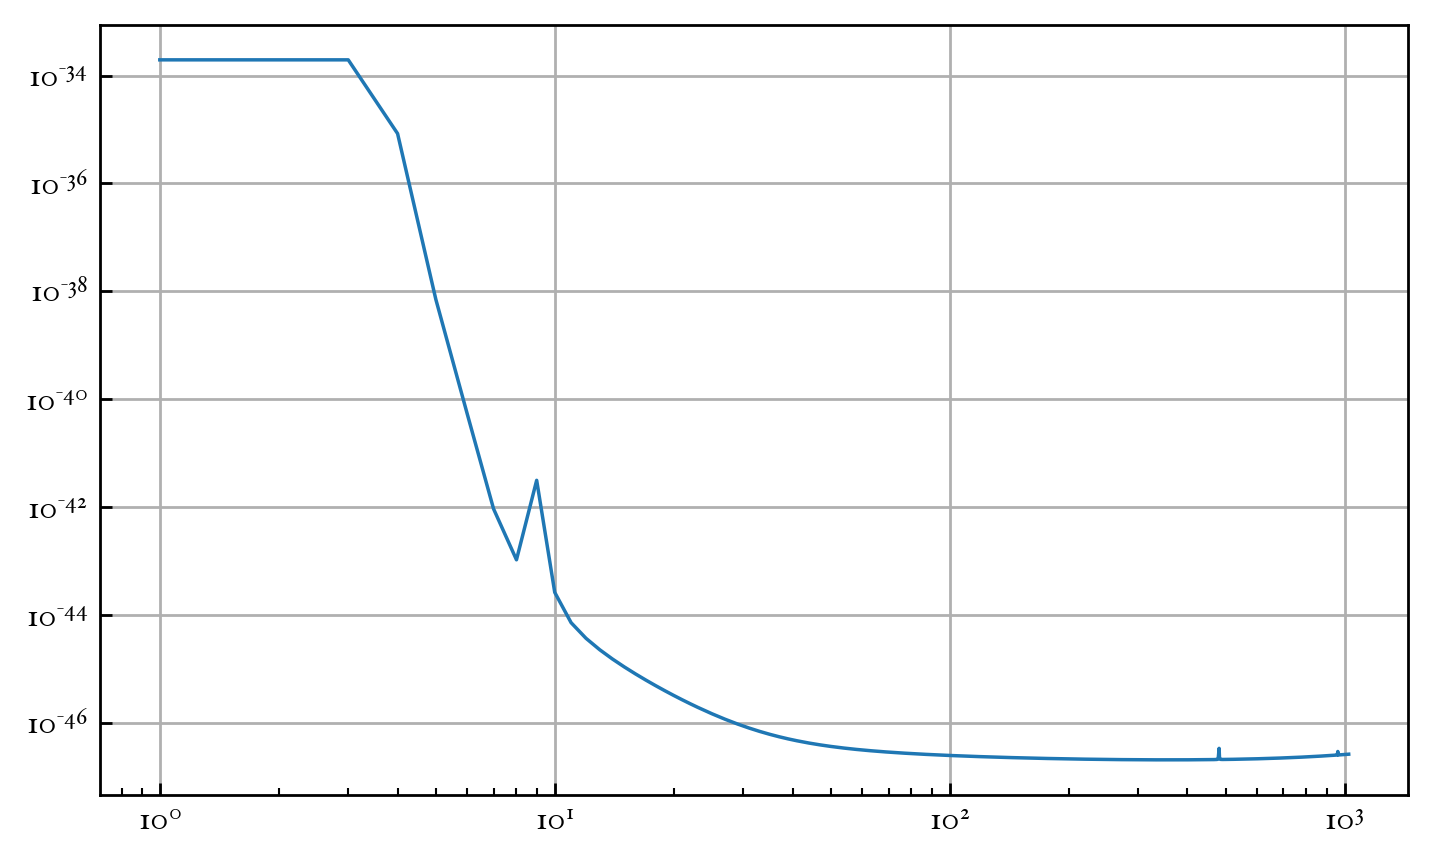

In [8]:
plt.loglog(freqs, psd_aligo_design_search_freqs)

In [9]:
Tobs = (86400 * 365.25)

In [10]:
sigma_aligo_design = sigma_of_f(psd_aligo_design_search_freqs, psd_aligo_design_search_freqs, Tobs, freqs, gamma_12)

In [11]:
fref = 25
omega_ref = 5e-9
alpha = 2/3
omega_of_f = omega_ref * (freqs / fref)**alpha
# get fake omega_gw "data" that we might measure
# by taking signal and adding noise to it that is consistent
# with our noise estimate
fake_omega_data = omega_of_f + np.random.randn(freqs.size) * sigma_aligo_design

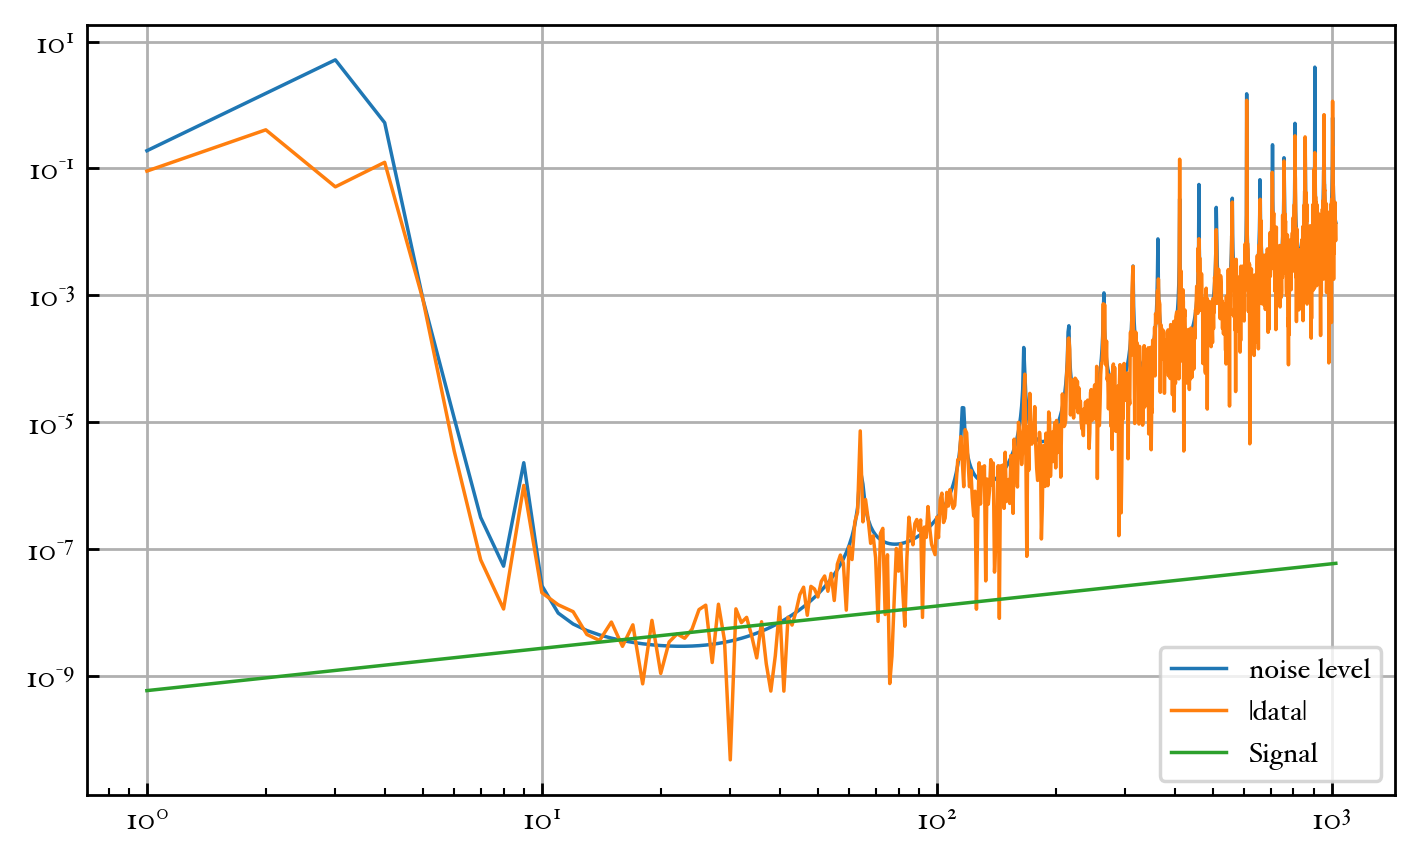

In [12]:
plt.loglog(freqs, sigma_aligo_design, label='noise level')
plt.loglog(freqs, np.abs(fake_omega_data), label='|data|')
plt.loglog(freqs, omega_of_f, label='Signal')
plt.legend()
plt.show()

In [13]:
def weight_function(freqs, alpha, fref=25):
    """calculate our weights (template)

    Parameters
    ----------
    freqs : np.ndarray
        frequencies
    alpha : float
        spectral index
    fref : float, optional
        reference frequency, by default 25

    Returns
    -------
    np.ndarray
        weight function
    """
    return (freqs / fref)**alpha

In [14]:
def omega_hat_sigma_omega(data, sigma, freqs, alpha_template, fref=25):
    """calculate omega_hat (at reference frequency) and its associated
    (theoretical) standard deviation

    Parameters
    ----------
    data : np.ndarray
        data (C(f) in our parlance)
    sigma : np.ndarray
        uncertainty (theoretical) on data
    freqs : np.ndarray 
        frequencies
    alpha_template : _type_
        template alpha for constructing estimator at reference frequency
    fref : float, optional
        reference frequency by default 25

    Returns
    -------
    omega_hat : float
        estimate of omega_gw at reference frequency
    sigma_hat : float
        error on omega_gw estimate at reference frequency
    """
    weights = weight_function(freqs, alpha_template)
    omega_hat = np.sum(weights * data * sigma**-2) / np.sum(weights**2 * sigma**-2)
    sigma_hat = np.sum(weights**2 * sigma**-2)**-0.5
    return omega_hat, sigma_hat

In [15]:
oh, sh = omega_hat_sigma_omega(fake_omega_data, sigma_aligo_design, freqs, 2/3)

In [16]:
snr = oh / sh
print(snr)

7.271951113887014


# Next steps

Ok, so we now have all the pieces. What we want now is to run the above code on outputs from our $\Omega_{gw}(f)$ estimates from different spin distributions.

In [17]:
# Read data
file_names = [
                # 'omegaGW_spins/omegaGW1_Callister.json', 
                '../notebooks/sgwb_calculation/omegaGW_spins/omegaGW1_highAligned.json',
                '../notebooks/sgwb_calculation/omegaGW_spins/omegaGW1_highAntiAligned.json',
                '../notebooks/sgwb_calculation/omegaGW_spins/omegaGW1_highTruncatedAligned.json',
                '../notebooks/sgwb_calculation/omegaGW_spins/omegaGW1_highTruncatedAntiAligned.json',
                '../notebooks/sgwb_calculation/omegaGW_spins/omegaGW1_lowTruncatedAligned.json',
                '../notebooks/sgwb_calculation/omegaGW_spins/omegaGW1_lowTruncatedAntiAligned.json',
                '../notebooks/sgwb_calculation/omegaGW_spins/omegaGW1_none.json',
                '../notebooks/sgwb_calculation/omegaGW_spins/omegaGW1_uniform.json'
            ]

freqs_data = []
OmegaGWs_data = []
for file in file_names:
    f = open(file)
    data = json.load(f)
    freqs_psd = data.get('freqs_psd')
    OmegaGWs = data.get('OmegaGWs')
    freqs_psd = json.loads(freqs_psd)
    OmegaGWs = json.loads(OmegaGWs)
    f.close()
    freqs_data.append(freqs_psd)
    OmegaGWs_data.append(OmegaGWs)

1.9915909368539608 : 2.505477560538951
1.0639077293270112 : 1.4222153951508099
1.801228317982095 : 2.277816295387068
1.1968117808031278 : 1.5864720232021972
1.6573966922999197 : 2.110809970262185
1.312730840260534 : 1.7138310725734556
1.4766933847860932 : 1.903401750511234
1.460917826957058 : 1.898835648642266


Text(0, 0.5, 'S/N')

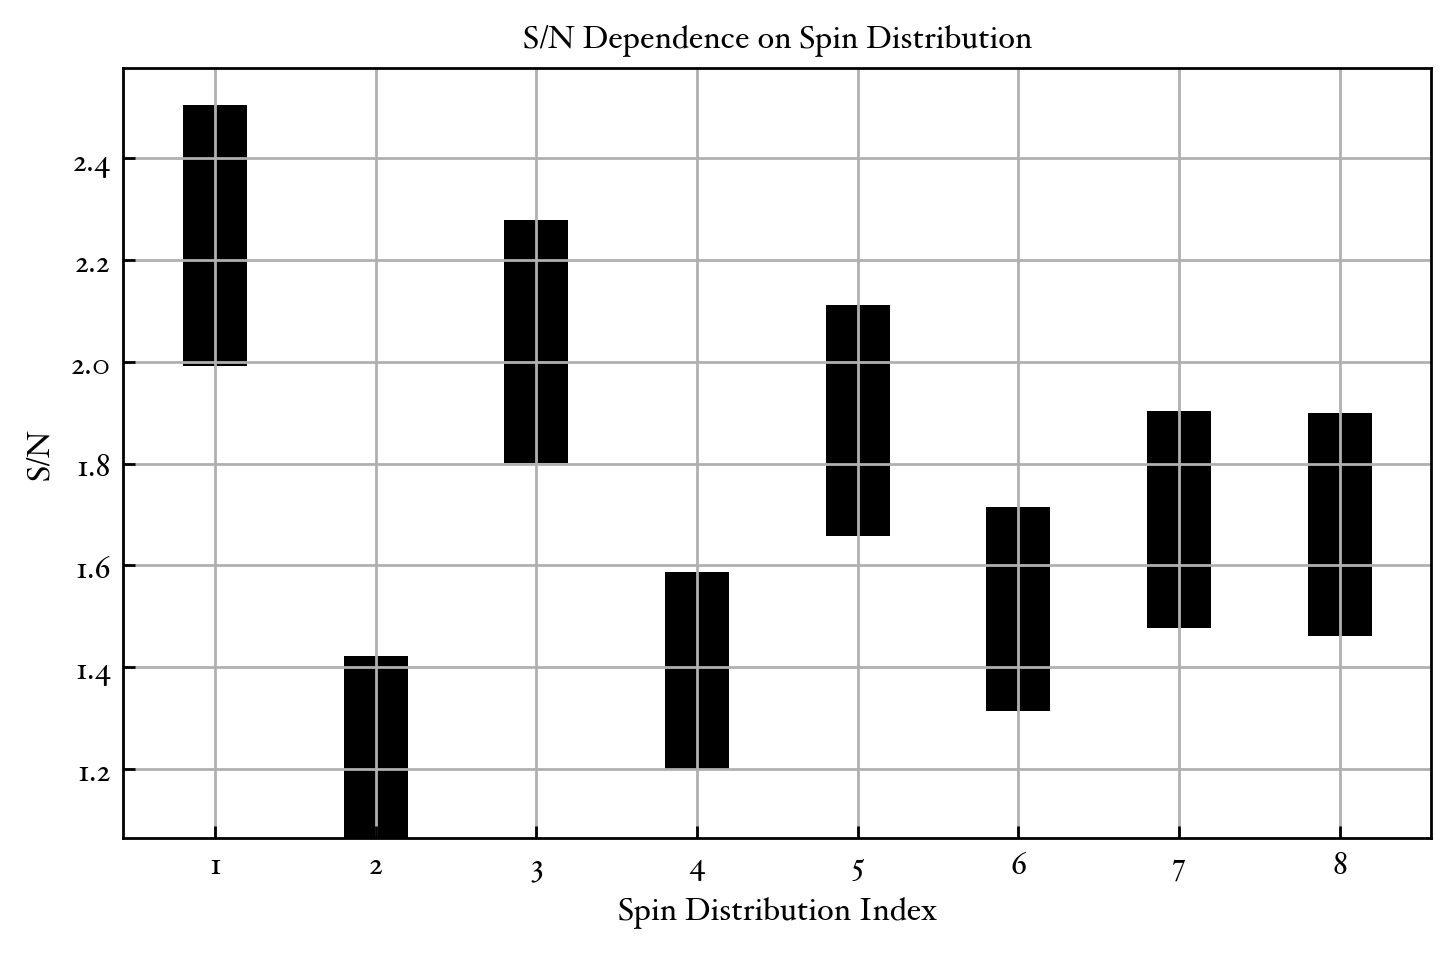

In [18]:
fig, ax = plt.subplots()
minSNRs = []
maxSNRs = []
differences = []
# names = ['High Aligned', 'High Anti-Aligned', 'High Truncated Aligned', 'High Truncated Anti Aligned', 'Low Truncated Aligned', 'Low Truncated Anti Aligned', 'None', 'Uniform']
names = ['1', '2', '3', '4', '5', '6', '7', '8']
for OmegaGW in OmegaGWs_data:
    oh5, sh5 = omega_hat_sigma_omega(np.delete(np.percentile(OmegaGW, 5, axis=0), 0), sigma_aligo_design, freqs, 2/3)
    snr5 = oh5 / sh5
    oh95, sh95 = omega_hat_sigma_omega(np.delete(np.percentile(OmegaGW, 95, axis=0), 0), sigma_aligo_design, freqs, 2/3)
    snr95 = oh95 / sh95
    minSNRs.append(snr5)
    maxSNRs.append(snr95)
    differences.append(snr95-snr5)
    print(str(snr5)+' : '+str(snr95))
ax.bar(names, differences, bottom=minSNRs, color ='black', width = 0.4)
ax.set_title('S/N Dependence on Spin Distribution')
ax.set_xlabel('Spin Distribution Index')
ax.set_ylabel('S/N')